In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [4]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
#!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

'Additional Testing Code'
'Basic Data'
 checkpoint
'Classifier Result.gsheet'
 converted_model.tflite
 frozen_har.pb
 history.p
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 human_activity_recognition_with_raw_data.ipynb
 predictions.p
'Processed Data'
'RNN Result.gsheet'
'Subject with number activities performed.gsheet'
 wisdomDataRemoveJoggingActivity.ipynb


# Load Library

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as AB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import skew, kurtosis, iqr, median_absolute_deviation, entropy
from sklearn.model_selection import KFold

from numpy.random import seed
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf

# Load Data

In [33]:
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_without_overlapping.csv')
df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_with_50_percent_overlapping.csv')

df.head()

,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-3.829004,4.742886,-7.083466,9.719741,1.449165,1.918649,1.357062,0.693729,4.094063,5.116266,7.212288,9.744467,-5.834961,1.516312,-9.491409,8.282956,-0.974731,8.014175,-4.099670,11.571552,-3.900444,5.047760,-7.240860,9.649097,1.194484,1.678672,1.159175,0.528726,0.907681,0.843915,0.871249,2,SITTING
2,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873054,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
3,-4.855590,1.370078,-8.583721,9.989439,0.660421,0.535662,0.498808,0.563156,4.900297,1.471071,8.598202,10.005300,-6.402389,-0.492416,-10.326981,8.587557,-2.504623,2.404571,-7.741241,12.089280,-4.892845,1.547440,-8.507393,9.955759,0.427754,0.419686,0.344539,0.368406,0.244587,0.540365,0.245289,2,SITTING
4,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING


# Data Exploration

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5026 entries, 0 to 5025
Data columns (total 33 columns):
mean_x              5026 non-null float64
mean_y              5026 non-null float64
mean_z              5026 non-null float64
magnitude_mean      5026 non-null float64
std_x               5026 non-null float64
std_y               5026 non-null float64
std_z               5026 non-null float64
magnitude_std       5026 non-null float64
rms_x               5026 non-null float64
rms_y               5026 non-null float64
rms_z               5026 non-null float64
magnitude_rms       5026 non-null float64
min_x               5026 non-null float64
min_y               5026 non-null float64
min_z               5026 non-null float64
magnitude_min       5026 non-null float64
max_x               5026 non-null float64
max_y               5026 non-null float64
max_z               5026 non-null float64
magnitude_max       5026 non-null float64
median_x            5026 non-null float64
median_y   

['SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


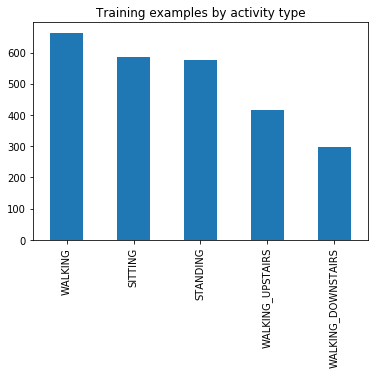

In [8]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');
unique_activities = np.unique(df['class'])
print(unique_activities)

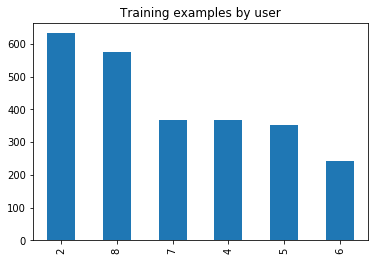

In [9]:
df['subject'].value_counts().plot(kind='bar', title='Training examples by user');

In [0]:
def plot_activity(subject, activity, df, activity_name):
  
  one_subject_segdata = df.loc[df['subject'] == subject]
  data = one_subject_segdata[one_subject_segdata['class'] == activity][['mean_x', 'mean_y',]][:100]
  axis = data.plot(subplots=True, figsize=(18, 14), 
                   title= 'Subject: '+str(subject) + ' Activity: '+activity_name)
  for ax in axis:
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

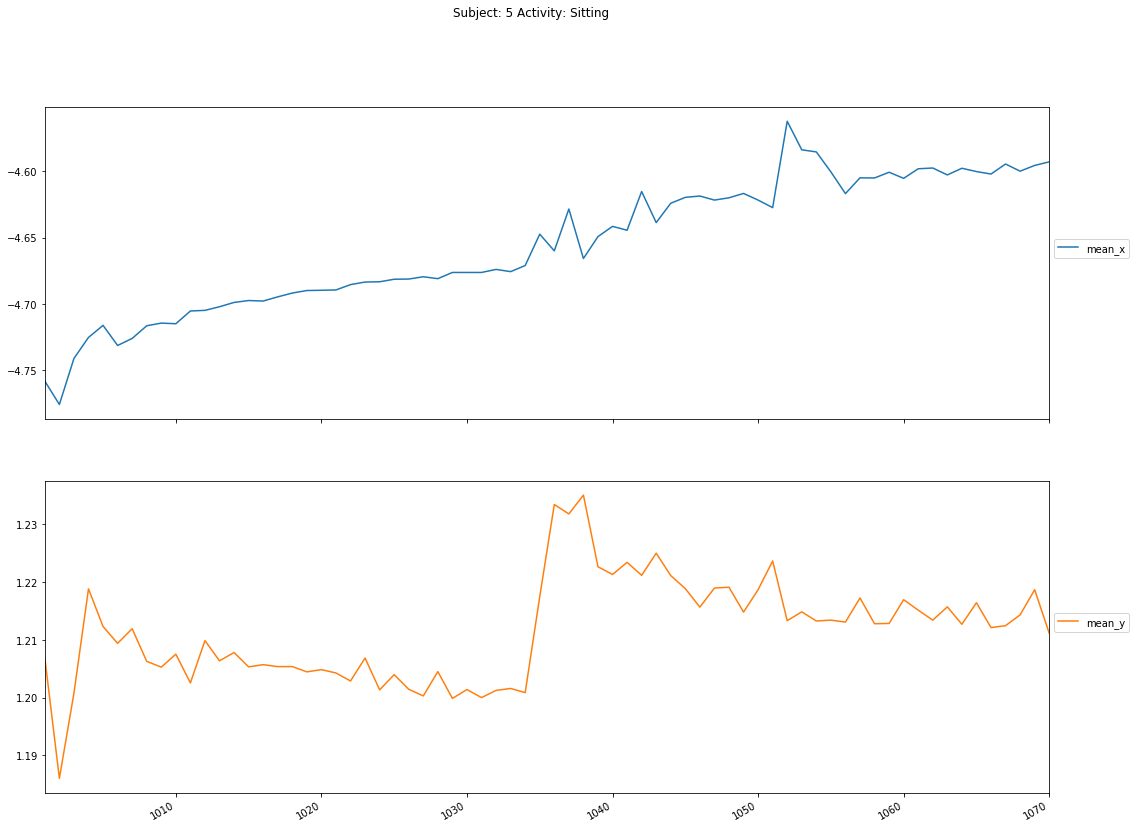

In [11]:
#plot_activity("Sitting", df)
plot_activity(5,"SITTING", df, "Sitting")

# Data Preprocessing

In [35]:
data = df.values
#print(data, data.shape)
X = data[:, 0:-2]
y= data[:, -1]
print(X, X.shape)
print (y, y.shape)

[[-1.64415131046 7.299988704000001 -4.7740188372 ... 0.8034815447440232
  0.7559010282155333 0.7245540302426258]
 [-3.829004223 4.742885724 -7.083465557999999 ... 0.9076806580805584
  0.8439150088929122 0.8712489457734718]
 [-4.89332215 2.3751165714000004 -8.347987354000002 ...
  0.1470292731461088 0.3300885734638331 0.2870609377851051]
 ...
 [-0.01657227800000005 8.276249664000003 -3.2166854829400005 ...
  -0.1033973455291868 0.4240943802002075 -0.3829888151459317]
 [-0.11822968288000005 8.192931501999999 -3.0778707822799984 ...
  -0.14560707387558708 0.5476891422921718 -0.4998458553525766]
 [-0.010255974918918937 7.760588543243241 -3.3170873300135115 ...
  -0.13691352726561 0.6125070571229589 -0.4347107948132072]] (5026, 31)
['SITTING' 'SITTING' 'SITTING' ... 'WALKING_UPSTAIRS' 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS'] (5026,)


In [36]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:,-1].astype('str'))+1
print(y)
print(len(y))

#subjects = [2,5,6,7]
subjects = np.unique(df['subject'])
print(subjects)

activity_ids = np.unique(y)
print(activity_ids)

n_class = len(activity_ids)
print(n_class)

[1 1 1 ... 5 5 5]
5026
[2 4 5 6 7 8]
[1 2 3 4 5]
5


In [0]:
def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Classifier

## KNN

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.8398406374501992
fold 1 : 0.855362519335392 0.8398406374501992 0.8374271862495214 0.8398406374501992
Testing Accuracy : 0.7681755829903978
fold 2 : 0.7517209221730188 0.7681755829903978 0.7545848150255825 0.7681755829903978
Testing Accuracy : 0.8094555873925502
fold 3 : 0.805422424610878 0.8094555873925502 0.807042809380993 0.8094555873925502
Testing Accuracy : 0.8160676532769556
fold 4 : 0.8669615035166206 0.8160676532769556 0.8229172876288264 0.8160676532769556
Testing Accuracy : 0.8385772913816689
fold 5 : 0.8554581916285846 0.8385772913816689 0.8407809285705238 0.8385772913816689
Testing Accuracy : 0.887719298245614
fold 6 : 0.8838070092482077 0.887719298245614 0.8850678600432292 0.887719298245614
overall: 0.8307704129889969 0.8336649423000398 0.8305103173861761 0.8336649423000398
class-wise precision: [0.99650044 0.99468556 0.74669312 0.53781513 0.70887728]
class-wise recall: [0.97684391 0.98250219 0.85725133 0.44

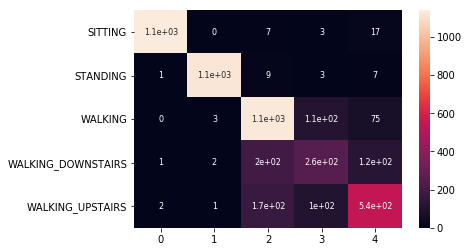

In [40]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = KNeighborsClassifier(n_neighbors=10, weights='distance')
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  #print(test_x, type(test_x), test_x.shape)
  #print(test_y, type(test_y), test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  #print("predicted probability ", pred_proba, type(pred_proba), len(pred_proba))
  #print("predicted activity ", )
  
  #print('length ' , len(list(test_y)),' ===== ', len(pred))
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## KNN k-fold

In [0]:
kf = KFold(n_splits=10)
print(kf.get_n_splits(df.values))
X = df.values[ : , : -1]
y = df.values[ : , -1]

cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []
print("fold # :  precision, recall, f1score, accuracy")
f = 0

print(X.shape, y.shape)
#print(len(df.values), df.values.shape)
for train_index, test_index in kf.split(df.values):
  #print(type(train_index), train_index.shape, test_index.shape)
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(y_train.astype('str'))+1
  train_x = X_train.astype(float)
  train_y = train_y.astype(int)
  
  clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
  clf.fit(train_x, train_y)
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(y_test.astype('str'))+1
  test_x = X_test.astype(float)
  test_y = test_y.astype(int)
  
  print(type(train_x), train_x.shape, type(train_y),train_y.shape)
  print(type(test_x), test_x.shape, type(test_y),test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  true = list(test_y)
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  #Predictions_test = clf.predict(test_x)
  #TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  #print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  #print(len(X_train), len(X_test))
  #print(len(y_train), len(y_test))
  f= f+1
  print("CM ", confusion_matrix(true, pred).shape)
  cm_all += confusion_matrix(true, pred)
  



10
fold # :  precision, recall, f1score, accuracy
(2538, 32) (2538,)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)
fold 1 : 1.0 0.9566929133858267 0.9778664967581949 0.9566929133858267
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


fold 2 : 0.027277840269966252 0.031496062992125984 0.02923558000226048 0.031496062992125984
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)
fold 3 : 0.963291537087276 0.7677165354330708 0.8375240564953362 0.7677165354330708
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


fold 4 : 0.645309871121879 0.6732283464566929 0.6505544395187267 0.6732283464566929
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)
fold 5 : 0.9580989876265467 0.8937007874015748 0.9232070720975517 0.8937007874015748
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


fold 6 : 0.7659623999317928 0.7519685039370079 0.7187025834596394 0.7519685039370079
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)
fold 7 : 0.8562793287202737 0.8149606299212598 0.819459165197933 0.8149606299212598
CM  (5, 5)
<class 'numpy.ndarray'> (2284, 32) <class 'numpy.ndarray'> (2284,)
<class 'numpy.ndarray'> (254, 32) <class 'numpy.ndarray'> (254,)
fold 8 : 0.28931894876776765 0.28346456692913385 0.2840688324953192 0.28346456692913385
CM  (5, 5)
<class 'numpy.ndarray'> (2285, 32) <class 'numpy.ndarray'> (2285,)
<class 'numpy.ndarray'> (253, 32) <class 'numpy.ndarray'> (253,)
fold 9 : 1.0 0.9841897233201581 0.9919110212335693 0.9841897233201581
CM  (4, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: ignored

In [0]:
ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)
class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))


array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()  

## Decission Tree

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.8231075697211155
fold 1 : 0.8348014961823021 0.8231075697211155 0.8083310657886612 0.8231075697211155
Testing Accuracy : 0.7722908093278463
fold 2 : 0.787952569904818 0.7722908093278463 0.7739219344157615 0.7722908093278463
Testing Accuracy : 0.8696275071633238
fold 3 : 0.8712363843121887 0.8696275071633238 0.8595295854054152 0.8696275071633238
Testing Accuracy : 0.7885835095137421
fold 4 : 0.8860342824580208 0.7885835095137421 0.8048979157471117 0.7885835095137421
Testing Accuracy : 0.8084815321477428
fold 5 : 0.8318789060082012 0.8084815321477428 0.8174555308909561 0.8084815321477428
Testing Accuracy : 0.9166666666666666
fold 6 : 0.920320056200623 0.9166666666666666 0.9177911445787464 0.9166666666666666
overall: 0.8352519498031071 0.838042180660565 0.8358165629715235 0.838042180660565
class-wise precision: [0.98440208 0.99376114 0.78710125 0.55040323 0.68103448]
class-wise recall: [0.97427101 0.97550306 0.86180714 0.

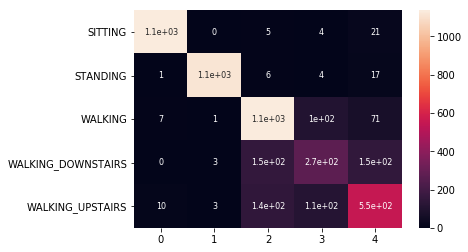

In [42]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  #clf = DT(max_leaf_nodes=20, random_state=42)
  clf = DT(max_depth =10, max_leaf_nodes=20, random_state=42)
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Random Forest

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = RF(n_estimators=100, max_depth=10, random_state=42)
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  #print(test_x, type(test_x), test_x.shape)
  #print(test_y, type(test_y), test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  #print("predicted probability ", pred_proba, type(pred_proba), len(pred_proba))
  #print("predicted activity ", )
  
  #print('length ' , len(list(test_y)),' ===== ', len(pred))
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

fold # :  precision, recall, f1score, accuracy


## Gaussian Naive Bayes

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.7483221476510067
fold 1 : 0.7433715131058147 0.7483221476510067 0.741135745565024 0.7483221476510067
Testing Accuracy : 0.6827195467422096
fold 2 : 0.7501124647495554 0.6827195467422096 0.7038145451696294 0.6827195467422096
Testing Accuracy : 0.7676348547717843
fold 3 : 0.7906410216412401 0.7676348547717843 0.7499096932571736 0.7676348547717843
Testing Accuracy : 0.7723577235772358
fold 4 : 0.800390979145793 0.7723577235772358 0.7785979155931628 0.7723577235772358
overall: 0.7476466466312504 0.7406819984139572 0.7424538696090207 0.7406819984139572
class-wise precision: [1.         1.         0.815625   0.11382114 0.43617021]
class-wise recall: [0.96785714 0.96363636 0.77448071 0.09395973 0.55909091]
class-wise f1score: [0.98366606 0.98148148 0.79452055 0.10294118 0.49003984]
class-wise accuracy: [0.96785714 0.96363636 0.77448071 0.09395973 0.55909091]
[[271   0   0   7   2]
 [  0 265   0  10   0]
 [  0   0 261  27  49]

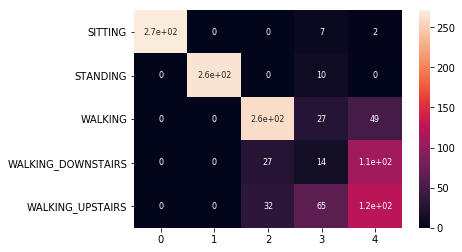

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = GaussianNB()
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Linear Model

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing Accuracy : 0.8523489932885906
fold 1 : 0.874104929474057 0.8523489932885906 0.8556920730347156 0.8523489932885906


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the 

Testing Accuracy : 0.5297450424929179
fold 2 : 0.7466387842548374 0.5297450424929179 0.47742069906187135 0.5297450424929179


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing Accuracy : 0.8298755186721992
fold 3 : 0.8114459476736753 0.8298755186721992 0.8174991583517325 0.8298755186721992


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing Accuracy : 0.7154471544715447
fold 4 : 0.8541586451593636 0.7154471544715447 0.6963642307626027 0.7154471544715447
overall: 0.7706671483328413 0.7176843774781919 0.7202734944877596 0.7176843774781919
class-wise precision: [0.96153846 0.94014085 0.67251462 0.30630631 0.78074866]
class-wise recall: [0.98214286 0.97090909 0.34124629 0.68456376 0.66363636]
class-wise f1score: [0.97173145 0.95527728 0.45275591 0.42323651 0.71744472]
class-wise accuracy: [0.98214286 0.97090909 0.34124629 0.68456376 0.66363636]
[[275   1   2   0   2]
 [  0 267   1   5   2]
 [  1   1 115 191  29]
 [  0   1  38 102   8]
 [ 10  14  15  35 146]]


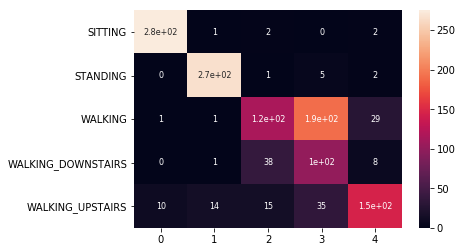

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = linear_model.LogisticRegression(penalty='l1')
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## MLP Classifier

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8456375838926175
fold 1 : 0.8718111694858636 0.8456375838926175 0.8461716635476204 0.8456375838926175


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8413597733711048
fold 2 : 0.8762738742081039 0.8413597733711048 0.8416669304114489 0.8413597733711048
Testing Accuracy : 0.7925311203319502
fold 3 : 0.8524377593360996 0.7925311203319502 0.7894296627218397 0.7925311203319502


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.7452574525745257
fold 4 : 0.8167774350118749 0.7452574525745257 0.7545756395525466 0.7452574525745257
overall: 0.8130733332096264 0.8049167327517843 0.8074901556852467 0.8049167327517843
class-wise precision: [0.99636364 0.96071429 0.79931973 0.50877193 0.62240664]
class-wise recall: [0.97857143 0.97818182 0.69732938 0.58389262 0.68181818]
class-wise f1score: [0.98738739 0.96936937 0.74484945 0.54375    0.65075922]
class-wise accuracy: [0.97857143 0.97818182 0.69732938 0.58389262 0.68181818]
[[274   1   1   1   3]
 [  0 269   2   4   0]
 [  0   3 235  37  62]
 [  0   1  35  87  26]
 [  1   6  21  42 150]]


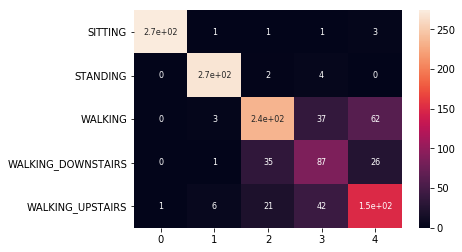

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = MLPClassifier(alpha=5,hidden_layer_sizes=(300, 6), random_state=1,solver='adam')
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.7785234899328859
fold 1 : 0.8023777594776268 0.7785234899328859 0.7715163007536091 0.7785234899328859


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.6827195467422096
fold 2 : 0.7596334711800425 0.6827195467422096 0.6796770367340639 0.6827195467422096


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8464730290456431
fold 3 : 0.8445430859789635 0.8464730290456431 0.8284148745963491 0.8464730290456431


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.6964769647696477
fold 4 : 0.7440626430871674 0.6964769647696477 0.6899038476091216 0.6964769647696477
overall: 0.7345252716198943 0.7406819984139572 0.7336895563488585 0.7406819984139572
class-wise precision: [0.98916968 0.96415771 0.68965517 0.17094017 0.5738255 ]
class-wise recall: [0.97857143 0.97818182 0.59347181 0.13422819 0.77727273]
class-wise f1score: [0.98384201 0.97111913 0.63795853 0.15037594 0.66023166]
class-wise accuracy: [0.97857143 0.97818182 0.59347181 0.13422819 0.77727273]
[[274   1   2   0   3]
 [  1 269   4   1   0]
 [  0   4 200  80  53]
 [  0   0  58  20  71]
 [  2   5  26  16 171]]


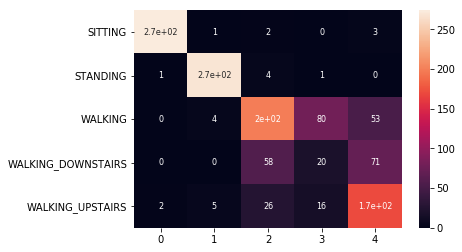

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = MLPClassifier(alpha=5,hidden_layer_sizes=(300, 6), random_state=1, solver ='sgd',max_iter=500 )
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Ada Boost

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.6342281879194631
fold 1 : 0.5361508228371795 0.6342281879194631 0.5592602069896484 0.6342281879194631


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.7280453257790368
fold 2 : 0.5716112211386598 0.7280453257790368 0.6287360346309323 0.7280453257790368


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.7178423236514523
fold 3 : 0.5958236345848935 0.7178423236514523 0.6327165933788108 0.7178423236514523


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  # Remove the CWD from sys.path while we load stuff.


Testing Accuracy : 0.4959349593495935
fold 4 : 0.3110302006555639 0.4959349593495935 0.3611301595869976 0.4959349593495935
overall: 0.5456290764778784 0.6360031720856463 0.5558153905098131 0.6360031720856463
class-wise precision: [0.99280576 0.96969697 0.42547771        nan        nan]
class-wise recall: [0.98571429 0.69818182 0.99109792 0.         0.        ]
class-wise f1score: [0.98924731 0.81183932 0.59536542        nan        nan]
class-wise accuracy: [0.98571429 0.69818182 0.99109792 0.         0.        ]
[[276   1   3   0   0]
 [  2 192  81   0   0]
 [  0   3 334   0   0]
 [  0   0 149   0   0]
 [  0   2 218   0   0]]


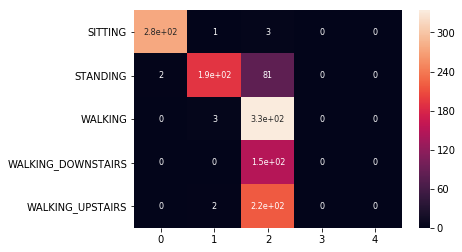

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = AB(n_estimators=100, random_state=42)
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Gradient Boost

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.9161073825503355
fold 1 : 0.9279764053816569 0.9161073825503355 0.9179296323139703 0.9161073825503355
Testing Accuracy : 0.830028328611898
fold 2 : 0.85778371664632 0.830028328611898 0.8365009280062518 0.830028328611898
Testing Accuracy : 0.8879668049792531
fold 3 : 0.8952282157676349 0.8879668049792531 0.8878451553282036 0.8879668049792531
Testing Accuracy : 0.7804878048780488
fold 4 : 0.8171647587838557 0.7804878048780488 0.7884843347474075 0.7804878048780488
overall: 0.8560980546062322 0.8469468675654243 0.8503106435233444 0.8469468675654243
class-wise precision: [1.         0.98884758 0.86513158 0.54705882 0.70247934]
class-wise recall: [0.98571429 0.96727273 0.78041543 0.62416107 0.77272727]
class-wise f1score: [0.99280576 0.97794118 0.82059282 0.5830721  0.73593074]
class-wise accuracy: [0.98571429 0.96727273 0.78041543 0.62416107 0.77272727]
[[276   0   0   3   1]
 [  0 266   5   1   3]
 [  0   0 263  44  30]
 [

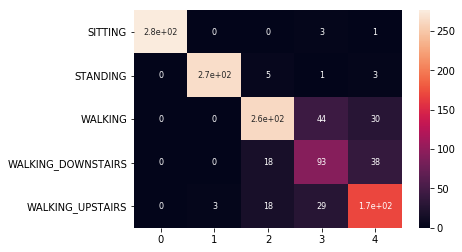

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = GB(n_estimators=100, random_state=42)
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## LDA Classifier

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.8691275167785235
fold 1 : 0.8979865771812081 0.8691275167785235 0.874214947724056 0.8691275167785235
Testing Accuracy : 0.5722379603399433
fold 2 : 0.7089352154507961 0.5722379603399433 0.5513382178239111 0.5722379603399433
Testing Accuracy : 0.8174273858921162
fold 3 : 0.8156605020256629 0.8174273858921162 0.8164656344116926 0.8174273858921162
Testing Accuracy : 0.7696476964769647
fold 4 : 0.8489396318494011 0.7696476964769647 0.777496769265062 0.7696476964769647
overall: 0.8016372522522325 0.7470261697065821 0.755503472247015 0.7470261697065821
class-wise precision: [1.         0.98168498 0.70588235 0.33950617 0.78378378]
class-wise recall: [0.98214286 0.97454545 0.4272997  0.73825503 0.65909091]
class-wise f1score: [0.99099099 0.97810219 0.5323475  0.46511628 0.71604938]
class-wise accuracy: [0.98214286 0.97454545 0.4272997  0.73825503 0.65909091]
[[275   1   2   0   2]
 [  0 268   1   5   1]
 [  0   0 144 165  28]


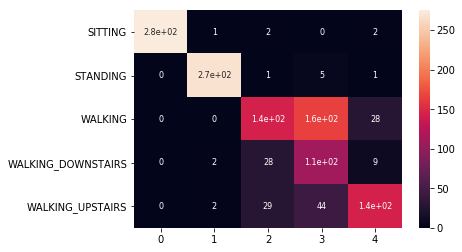

In [0]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = LinearDiscriminantAnalysis()
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## SVM

In [32]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

acc = 0
c=0

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  #clf = svm.SVC(gamma='auto')
  clf = svm.SVC(kernel = 'rbf', gamma='scale')
  #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ gamma= scale
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  '''
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  '''
  
  Predictions_test = clf.predict(test_x)
  #print(Predictions_test, type(Predictions_test))
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("fold", f+1,":","Testing Accuracy : {}".format(TestAccuracy))
  
  acc = acc+TestAccuracy
  c =c+1
  
  ar = confusion_matrix(test_y, Predictions_test)
  #print(ar, type (ar), ar.shape)
  
  #print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(test_y, Predictions_test)
  print(cm_all)

#ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
#ov_accuracy = accuracy_score(true_all, pred_all)

#print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)
print("overall accuracy  ", acc/c)
class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))





fold # :  precision, recall, f1score, accuracy
fold 1 : Testing Accuracy : 0.8069620253164557
[[150.   0.   4.   0.   3.]
 [  0. 137.   4.   0.   0.]
 [  0.   0. 112.   1.   0.]
 [  0.   0.  25.  17.  58.]
 [  0.   0.  24.   3.  94.]]
fold 2 : Testing Accuracy : 0.7804878048780488
[[219.   0.   4.   0.   3.]
 [  0. 203.   4.   0.   0.]
 [  0.   0. 228.   7.   5.]
 [  0.   0.  59.  29.  63.]
 [  0.   0.  43.  15. 119.]]
fold 3 : Testing Accuracy : 0.9206798866855525
[[289.   0.   4.   0.   3.]
 [  0. 260.   4.   0.   0.]
 [  0.   0. 346.  10.  14.]
 [  0.   0.  65.  62.  66.]
 [  2.   0.  48.  15. 166.]]
fold 4 : Testing Accuracy : 0.8423236514522822
[[346.   0.   4.   0.   3.]
 [  0. 321.   4.   1.   0.]
 [  0.   0. 397.  14.  14.]
 [  0.   0.  74.  70.  66.]
 [  2.   0.  56.  31. 192.]]
fold 5 : Testing Accuracy : 0.8184281842818428
[[422.   1.   4.   0.   4.]
 [  0. 397.   7.   1.   0.]
 [  0.   0. 472.  28.  31.]
 [  0.   0.  77. 102.  77.]
 [  2.   2.  56.  46. 235.]]
fold 6 : Test